In [1]:
#!pip install unidecode

In [2]:
#!pip install imbalanced-learn

In [3]:
#!pip install delayed

# Projet Analyse de Données - Année scolaire 2020-2021 ~ Johana LABOU

## Introduction

Pour ce projet, j'ai décidé de m'intéresser à la composition de l'équipe de France de football.
Plus précisément, je vais créer un modèle permettant de prédire la sélection ou non-sélection des joueurs par Didier Deschamps pour l'EDF.

Pour ce faire, j'ai choisi d'utiliser le jeu de données suivant : https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset

Il s'agit de la base de données officielle de la série de jeux vidéo FIFA, qui regroupe les caractéristiques de tous les joueurs du jeu de 2015 à 2021. Ces données sont une bonne représentation des joueurs dans la vraie vie.

Il s'agit d'un problème de classification binaire (un joueur est sélectionné en EDF ou bien il ne l'est pas). 

## Importation des librairies et des données 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import imblearn
import math
from math import pi
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

Mon dataset contient 7 fichiers csv pour les années 2015, 2016, 2017, 2018, 2019, 2020 et 2021.
N'ayant pas trouvé de document regroupant tous les joueurs sélectionnés en EDF pour cette période, j'ai moi-même créé un excel avec ces données, que j'ai par la suite converti en .csv. 

Dans la cellule suivante, je crée un dataframe pour chacun de ces fichiers.

In [5]:
players_15 = pd.read_csv('players_15.csv')
players_15['selection_year'] = '2015' #Ajout d'une colonne dans le dataframe correspondant à l'année en cours
players_16 = pd.read_csv('players_16.csv')
players_16['selection_year'] = '2016'
players_17 = pd.read_csv('players_17.csv')
players_17['selection_year'] = '2017'
players_18 = pd.read_csv('players_18.csv')
players_18['selection_year'] = '2018'
players_19 = pd.read_csv('players_19.csv')
players_19['selection_year'] = '2019'
players_20 = pd.read_csv('players_20.csv')
players_20['selection_year'] = '2020'
players_21 = pd.read_csv('players_21.csv')
players_21['selection_year'] = '2021'
selected_players = pd.read_csv('selected_players_15-21.csv', sep=';') #dataframe du .csv contenant la liste des joueurs selectionnes en EDF de 2015 à 2021

In [6]:
selected_players['Année'] = selected_players['Année'].astype(str) #Conversion des colonnes années en type str

La cellule suivante sert à concaténer tous les dataframes players_XX en un seul appelé "players_df".

In [7]:
players_df = players_15.append([players_16, players_17, players_18, players_19, players_20, players_21])

In [8]:
#On affiche les 5 premieres lignes de players_df
players_df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,selection_year
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,2015
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,2015
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,...,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,2015
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,...,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3,2015
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,...,40+3,40+3,40+3,36+3,36+3,38+3,38+3,38+3,36+3,2015


In [9]:
#On affiche le nombre de lignes et de colonnes de players_df
players_df.shape

(122841, 107)

Le dataframe 'players_df' contient désormais les données de TOUS les joueurs des jeux FIFA de 2015 à 2021. On voit qu'il comporte 122 841 lignes (une ligne par joueur) et 107 colonnes (une colonne par attribut).

## Pré-traitement des données

Dans notre problème, nous ne nous intéressons qu'aux joueurs susceptibles d'être sélectionnés en EDF, c'est-à-dire les joueurs de nationalité française. 

Dans la celulle suivante, nous faisons donc une sélection sur la colonne 'nationality'.
Nous faisons ensuite le choix d'enlever tous les accents et les majuscules pour prévenir d'éventuelles erreurs de casse/d'accent plus tard.

In [10]:
players_df = players_df[players_df['nationality']=='France']
players_df['long_name'] = players_df['long_name'].apply(lambda x : unidecode.unidecode(x)) #pour chaque ligne du dataframe, on applique la fonction unidecode.unidecode() qui remplace tous les caracteres speciaux en caracteres ASCII dans la colonne "long_name"
players_df['long_name'] = players_df['long_name'].apply(lambda x : x.lower()) #pour chaque ligne du df, on remplace toutes les majuscules par des minuscules dans la colonne "long_name"

In [11]:
#On affiche le nombre de lignes et de colonnes de players_df
players_df.shape

(6764, 107)

On voit que parmi les 122 841 joueurs, 6 764 sont français. Affichons les 3 premieres lignes de players_df :

In [12]:
#On affiche les 3 premières ligne de players_df
players_df.head(3)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,selection_year
10,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,franck bilal ribery,31,1983-04-07,170,72,France,FC Bayern München,...,63+2,63+2,63+2,63+2,53+2,44+2,44+2,44+2,53+2,2015
35,165153,https://sofifa.com/player/165153/karim-benzema...,K. Benzema,karim benzema,26,1987-12-19,184,79,France,Real Madrid,...,58+2,58+2,58+2,58+2,53+2,49+2,49+2,49+2,53+2,2015
39,167948,https://sofifa.com/player/167948/hugo-lloris/1...,H. Lloris,hugo lloris,27,1986-12-26,188,78,France,Tottenham Hotspur,...,35+1,35+1,35+1,35+1,34+1,33+1,33+1,33+1,34+1,2015


Les 3 premiers joueurs du nouveau players_df sont bien français, et on remarque que leurs noms dans la colonne long_name sont bien écrits en minuscule et sans accents.

Intéressons-nous à présent au dataframe 'selected_players' :

In [13]:
selected_players.head()

,Année,Joueurs,Poste
0,2015,Hugo Lloris,G
1,2015,Steve Mandanda,G
2,2015,Stéphane Ruffier,G
3,2015,Patrice Evra,D
4,2015,Benoît Trémoulinas,D


S'agissant d'un problème de classification binaire, on met à 1 les joueurs qui ont déjà été sélectionnés par le passé (à savoir tous les joueurs du dataframe "selected_players") en créant une nouvelle colonne 'selected'.

Ensuite, on renomme les colonnes "Année" et "Joueurs" de selected_players pour qu'elles aient le même nom que les colonnes dans players_df. Enfin, comme pour players_df, on enlève tous les accents et majuscule dans les noms des joueurs.

In [14]:
selected_players['selected'] = 1
selected_players.rename(columns = {'Année':'selection_year', 'Joueurs':'long_name' }, inplace=True)
selected_players['long_name'] = selected_players['long_name'].apply(lambda x : unidecode.unidecode(x))
selected_players['long_name'] = selected_players['long_name'].apply(lambda x : x.lower())

In [15]:
selected_players.head()

,selection_year,long_name,Poste,selected
0,2015,hugo lloris,G,1
1,2015,steve mandanda,G,1
2,2015,stephane ruffier,G,1
3,2015,patrice evra,D,1
4,2015,benoit tremoulinas,D,1


L'affichage nous montre bien que le renommage des colonnes a bien été fait, que les noms des joueurs ont bien été mis en minuscule et sans accent, et que la colonne selected a bien été mise à 1 pour tout le monde.

Nous pouvons donc effectuer la jointure de players_df et selected_players sur les colonnes correspondant à l'année de sélection et au nom des joueurs.
On nomme le nouveau dataframe obtenu "full_df". Il s'agit du dataframe sur lequel nous allons travailler par la suite.

In [16]:
full_df = players_df.merge(selected_players,  on = ['selection_year', 'long_name'], how='left')

L'attribut how='left' de la fonction merge() indique que nous choisissons d'effectuer une jointure à gauche sur players_df.
Le nombre de lignes de full_df devrait donc être égal au nombre de lignes de players_df, ce que vérifie la cellule suivante :

In [17]:
full_df.shape

(6764, 109)

Maintenant que nous avons notre dataframe, il nous faut mettre à 0 tous les joueurs qui n'ont jamais été selectionnés :

In [18]:
full_df['selected'] = full_df['selected'].fillna(0)

In [19]:
full_df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,...,rdm,rwb,lb,lcb,cb,rcb,rb,selection_year,Poste,selected
0,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,franck bilal ribery,31,1983-04-07,170,72,France,FC Bayern München,...,63+2,63+2,53+2,44+2,44+2,44+2,53+2,2015,NaN,0.0
1,165153,https://sofifa.com/player/165153/karim-benzema...,K. Benzema,karim benzema,26,1987-12-19,184,79,France,Real Madrid,...,58+2,58+2,53+2,49+2,49+2,49+2,53+2,2015,A,1.0
2,167948,https://sofifa.com/player/167948/hugo-lloris/1...,H. Lloris,hugo lloris,27,1986-12-26,188,78,France,Tottenham Hotspur,...,35+1,35+1,34+1,33+1,33+1,33+1,34+1,2015,G,1.0
3,165239,https://sofifa.com/player/165239/samir-nasri/1...,S. Nasri,samir nasri,27,1987-06-26,175,75,France,Manchester City,...,64+1,65+1,57+1,50+1,50+1,50+1,57+1,2015,NaN,0.0
4,195864,https://sofifa.com/player/195864/paul-pogba/15...,P. Pogba,paul pogba,21,1993-03-15,188,80,France,Juventus,...,79+1,78+1,78+1,79+1,79+1,79+1,78+1,2015,M,1.0


## Quelques graphiques...

Dans cette partie, on s'attache à faire ressortir par des graphiques explicites quelques informations intéressantes fournies par nos données.
Dans ce premier graphique par exemple, nous montrons le rapport entre le salaire annuel des joueurs et leur note globale attribuée par FIFA.

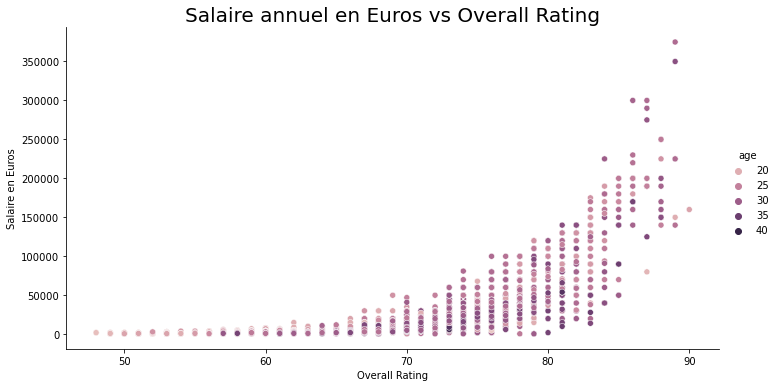

In [20]:
sns.relplot(x='overall', y='wage_eur', hue='age', sizes=(15, 200), aspect=2, data=full_df)
plt.title('Salaire annuel en Euros vs Overall Rating',fontsize = 20)
plt.xlabel('Overall Rating')
plt.ylabel('Salaire en Euros')
plt.show()

Il apparait clairement qu'il existe une corrélation entre le niveau d'un joueur et son salaire. Grossièrement, on pourrait résumer cela de la manière suivante : plus un joueur est fort, et plus il a un gros salaire.

Nous nous intéressons maintenant à la saison 2021. Le prochain graphique montre la moyenne d'age des joueurs français pour l'année 2021.

In [21]:
df_2021 = full_df[full_df['selection_year']=='2021'] # On ne garde que les joueurs français de 2021

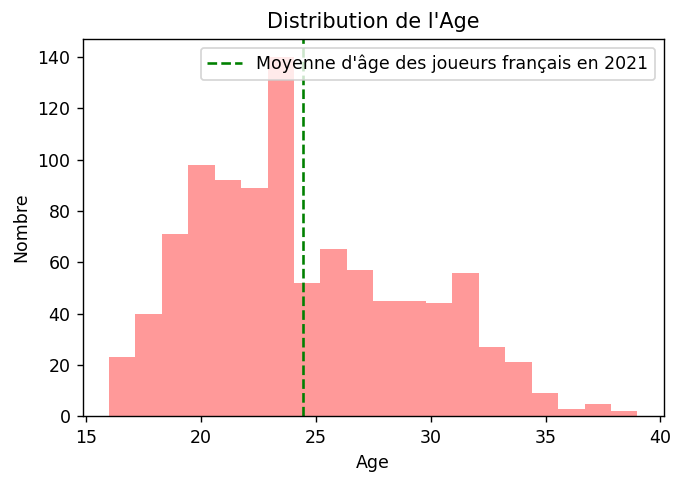

In [22]:
plt.figure(dpi=125)
sns.distplot(a=df_2021['age'],kde=False,bins=20,color='red')
plt.axvline(x=np.mean(df_2021['age']),c='green',ls='--',label="Moyenne d'âge des joueurs français en 2021")
plt.legend()
plt.xlabel('Age')
plt.ylabel('Nombre')
plt.title("Distribution de l'Age")
plt.show()

D'après cet histogramme, la moyenne d'age des joueurs français en 2021 se situe quelque part entre 24 et 25 ans. Vérifions cela :

In [23]:
df_2021['age'].mean()

24.443089430894307

Enfin, le tableau suivant montre les 2 "meilleurs" français, c'est-à-dire ceux qui ont les stats les plus élevées parmi 8 critères (colonnes) que j'ai choisi. On aurait pu les comparer selon d'autres attributs.

In [24]:
column_r=['short_name','overall','potential','pace','shooting','passing','dribbling','defending','physic']
rival = df_2021.head(2)[column_r]
rival = rival.set_index('short_name')
rival.head()

,overall,potential,pace,shooting,passing,dribbling,defending,physic
short_name,,,,,,,,
K. Mbappé,90,95,96.0,86.0,78.0,91.0,39.0,76.0
K. Benzema,89,89,74.0,85.0,81.0,86.0,40.0,76.0


Le résultat nous montre que les deux meilleurs français selon mes critères sont Mbappe et Benzema. Intéressons-nous plus en détail à cette "rivalité". Le code suivant nous montre un graphique nous permettant de mieux apprécier les performances de chaque joueur :

In [25]:
values = rival.iloc[0].tolist()
values += values [:1]
values #On recupere ici les valeurs de chaque attribut de 'rival' car nous en aurons besoin pour le graphique

[90.0, 95.0, 96.0, 86.0, 78.0, 91.0, 39.0, 76.0, 90.0]

In [26]:
values2 = rival.iloc[1].tolist()
values2 += values2[:1]
values2

[89.0, 89.0, 74.0, 85.0, 81.0, 86.0, 40.0, 76.0, 89.0]

In [27]:
def RadarChart(player, data, player2, data2):
    Attributes = ["Overall","Potential","Pace","Shooting","Passing","Dribbling","Defending","Physical"]

    data += data [:1]
    data2 += data2 [:1]
    
    angles = [n / 8 * 2 * pi for n in range(8)]
    angles += angles [:1]
    
    angles2 = [n / 8 * 2 * pi for n in range(8)]
    angles2 += angles2 [:1]
    
    plt.figure(dpi=125)
    ax = plt.subplot(111, polar=True)
    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1],Attributes)

    ax.plot(angles,values)
    ax.fill(angles, values, 'teal', alpha=0.1)

    ax.plot(angles2,values2)
    ax.fill(angles2, values2, 'red', alpha=0.1)

    plt.figtext(0.1,0.98,player,color="steelblue")
    plt.figtext(0.1,0.94,"vs")
    plt.figtext(0.1,0.9,player2,color="darkorange")
    
    plt.show()

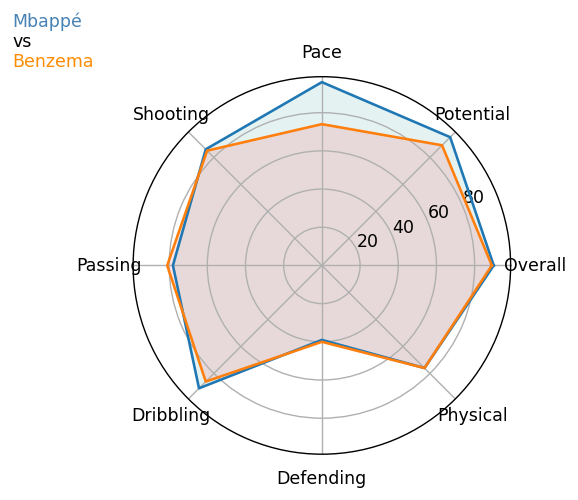

In [28]:
RadarChart('Mbappé',[90.0, 95.0, 96.0, 86.0, 78.0, 91.0, 39.0, 76.0, 90.0], "Benzema", [89.0, 89.0, 74.0, 85.0, 81.0, 86.0, 40.0, 76.0, 89.0])

Sur ce graphique, les données de Mbappe sont représentées en bleu et celles de Benzema en orange. Il apparaît clairement que Mbappe est plus rapide (pace) et a un plus gros potentiel que Benzema (ce qui est tout à fait cohérent avec la réalité étant donné qu'il est plus jeune). Il est également légèrement meilleur en dribles.

## Réduction des données

Revenons à nos données. Notre dataframe comporte 109 colonnes, ce qui est beaucoup. Nous allons donc choisir les colonnes qui nous semblent pertinentes pour répondre à notre problématique et ainsi réduire la taille de full_df.
Le choix des colonnes retenues est le mien et peut différer d'une personne à une autre.

In [29]:
full_df = full_df[['long_name',
'age',
'team_position', #poste du joueur dans son club
'player_positions', #postes auxquels peut jouer le joueur
'club_name',
'overall',
'potential',
'pace',
'shooting',
'passing',
'dribbling',
'physic',
'gk_diving',
'gk_handling',
'gk_kicking',
'gk_reflexes',
'gk_speed',
'gk_positioning',
'attacking_crossing',
'attacking_finishing',
'attacking_heading_accuracy',
'attacking_volleys',
'skill_dribbling',
'skill_curve',
'skill_long_passing',
'skill_ball_control',
'movement_acceleration',
'movement_sprint_speed',
'movement_agility',
'movement_balance',
'power_shot_power',
'power_jumping',
'power_stamina',
'power_strength',
'power_long_shots',
'mentality_aggression',
'mentality_positioning',
'mentality_vision',
'mentality_penalties',
'mentality_composure',
'defending_marking',
'defending_standing_tackle',
'defending_sliding_tackle',
'selected']]

In [30]:
full_df.shape # Il ne nous reste plus que 44 colonnes

(6764, 44)

In [31]:
full_df.head()

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,power_long_shots,mentality_aggression,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected
0,franck bilal ribery,31,SUB,LM,FC Bayern München,88,88,89.0,78.0,85.0,...,73,52,83,88,80,NaN,25.0,25,26,0.0
1,karim benzema,26,ST,ST,Real Madrid,85,87,84.0,84.0,75.0,...,78,65,87,81,82,NaN,25.0,25,25,1.0
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,25,31,25,25,40,NaN,25.0,25,25,1.0
3,samir nasri,27,SUB,"LM, RM",Manchester City,84,86,79.0,76.0,84.0,...,77,33,81,85,81,NaN,35.0,37,44,0.0
4,paul pogba,21,LCM,"CM, CAM",Juventus,83,89,76.0,78.0,79.0,...,88,85,77,83,67,NaN,63.0,79,83,1.0


In [32]:
full_df.describe()

,age,overall,potential,pace,shooting,passing,dribbling,physic,gk_diving,gk_handling,...,power_long_shots,mentality_aggression,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected
count,6764.000000,6764.00000,6764.000000,6021.000000,6021.000000,6021.000000,6021.000000,6021.000000,743.000000,743.000000,...,6764.000000,6764.000000,6764.000000,6764.000000,6764.000000,4901.000000,4776.000000,6764.000000,6764.000000,6764.000000
mean,24.553223,66.86709,72.531342,67.682943,52.016941,58.505066,62.869955,65.026906,66.670256,63.627187,...,46.943081,56.330574,49.711561,53.236694,49.912921,58.701694,46.455611,49.283116,47.399172,0.029273
std,4.684956,7.12128,6.450512,10.848058,14.450892,10.622229,10.568124,10.097183,7.488555,8.038798,...,18.942652,17.397514,19.262102,15.487428,15.676823,12.526021,21.576556,22.539061,22.081564,0.168582
min,16.000000,48.00000,53.000000,21.000000,18.000000,27.000000,22.000000,28.000000,46.000000,46.000000,...,5.000000,11.000000,2.000000,7.000000,7.000000,13.000000,5.000000,7.000000,5.000000,0.000000
25%,21.000000,62.00000,68.000000,62.000000,40.000000,52.000000,57.000000,58.000000,61.000000,58.000000,...,32.000000,44.000000,38.000000,43.000000,41.000000,51.000000,25.000000,26.000000,25.000000,0.000000
50%,24.000000,66.00000,72.000000,68.000000,54.000000,59.000000,64.000000,66.000000,66.000000,63.000000,...,50.000000,60.000000,54.000000,55.000000,51.000000,60.000000,52.000000,58.000000,56.000000,0.000000
75%,28.000000,72.00000,77.000000,75.000000,63.000000,66.000000,70.000000,72.000000,72.000000,69.000000,...,62.000000,70.000000,64.000000,65.000000,62.000000,67.000000,65.000000,68.000000,66.000000,0.000000
max,41.000000,90.00000,95.000000,96.000000,86.000000,87.000000,92.000000,89.000000,89.000000,87.000000,...,91.000000,92.000000,91.000000,88.000000,91.000000,90.000000,90.000000,91.000000,88.000000,1.000000


Il existe de nombreux postes (positions) au sein d'une équipe de foot. Par exemple, les postes d'arrières latéraux et de défenseurs centraux sont tous des positions de défense, mais ne se situent pas tous au même endroit sur un terrain. Dans la celulle suivante, pour simplifier tout cela, nous créons un dictionnaire avec 4 clés: "gardien", "defense", "milieu" et "attaque", auxquelles on va attribuer les différentes valeurs correspondant aux initiales de tous les postes existants (et que l'on retrouve dans notre dataframe).

In [33]:
dict_position = {
    'gardien':['GK'],
    'defense':['LWB', 'LB', 'LCB', 'SW', 'CB', 'RCB', 'RB', 'RWB'],
    'milieu':['LM', 'LCM','LDM','CM','CDM','RCM','RDM','RM','RWB','CAM','LAM'],
    'attaque':['LW', 'LS', 'ST', 'CF', 'RS', 'RW']    
}

Dans la réalité, un joueur peut être en mesure de jouer à plusieurs postes différents. Plus précisément, il est possible qu'un joueur puisse jouer à la fois en tant que défenseur ou milieu de terrain par exemple, cela dépend du choix de l'entraineur. Ici, dans un soucis de simplification, nous allons considérer qu'un joueur ne peut être que soit un défenseur, soit un milieu, soit un attaquant (la question ne se pose pas pour un gardien de but) sans préciser son poste particulièrement. 

Pour ce faire, nous implémentons la fonction get_player_position_from_team_position(team_position) pour répartir les joueurs en fonction de leur poste dans leur club. Cette fonction prend en argument un poste (team_position) et parcours les valeurs du dictionnaire dict_position pour enfin retourner la clé correspondante.

L'idée derrière cette manipulation est que l'on considère que le poste d'un joueur en équipe de France est le même que celui de son club.

In [34]:
def get_player_position_from_team_position(team_position:str):
    for key, item in dict_position.items():
        if team_position in item :
            return key

Dans la celulle suivante, on crée une nouvelle colonne "poste" qu'on remplit en appliquant get_player_position_from_team_position(team_position) à toutes les lignes de full_df :

In [35]:
full_df['poste'] = full_df['team_position'].apply(lambda x: get_player_position_from_team_position(x))

In [36]:
full_df.head(3)

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,mentality_aggression,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected,poste
0,franck bilal ribery,31,SUB,LM,FC Bayern München,88,88,89.0,78.0,85.0,...,52,83,88,80,NaN,25.0,25,26,0.0,None
1,karim benzema,26,ST,ST,Real Madrid,85,87,84.0,84.0,75.0,...,65,87,81,82,NaN,25.0,25,25,1.0,attaque
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,31,25,25,40,NaN,25.0,25,25,1.0,gardien


La colonne "poste" a bien été ajoutée, mais on remarque qu'il y a des valeurs manquantes (pour Frank Ribéry par exemple). Cela arrive lorsqu'un joueur est remplaçant dans son club. On remplace dans un premier temps ces valeurs manquantes par "unknown".

In [37]:
full_df['poste'].fillna('unknown', inplace=True)

Le but à partir de maintenant est de remplir ces valeurs manquantes par de vraies valeurs. Comme je l'ai dit plus haut, il est tout à fait possible qu'un joueur soit en mesure de jouer à plusieurs postes, bien qu'il soit remplaçant dans son club. Dans notre dataframe, c'est la colonne "player_positions" qui nous indique tous les postes auquels peut jouer un joueur. Ici, nous implémentons une fonction get_position_from_player_position(player_position) qui prend en argument les postes des joueurs et qui renvoie une liste de ces postes.

In [38]:
def get_position_from_player_position (player_position: str):
    return player_position.split(',')

Une fois de plus, on crée une nouvelle colonne que l'on nomme "list_player_positions" que l'on remplit en appliquant pour chaque ligne la fonction get_position_from_player_position :

In [39]:
full_df['list_player_positions'] = full_df['player_positions'].apply(lambda x: get_position_from_player_position(x))

In [40]:
full_df.head()

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected,poste,list_player_positions
0,franck bilal ribery,31,SUB,LM,FC Bayern München,88,88,89.0,78.0,85.0,...,83,88,80,NaN,25.0,25,26,0.0,unknown,[LM]
1,karim benzema,26,ST,ST,Real Madrid,85,87,84.0,84.0,75.0,...,87,81,82,NaN,25.0,25,25,1.0,attaque,[ST]
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,25,25,40,NaN,25.0,25,25,1.0,gardien,[GK]
3,samir nasri,27,SUB,"LM, RM",Manchester City,84,86,79.0,76.0,84.0,...,81,85,81,NaN,35.0,37,44,0.0,unknown,"[LM, RM]"
4,paul pogba,21,LCM,"CM, CAM",Juventus,83,89,76.0,78.0,79.0,...,77,83,67,NaN,63.0,79,83,1.0,milieu,"[CM, CAM]"


On crée maintenant une colonne "poste_provisoire" que l'on remplit en appliquant la fonction get_player_position_from_team_position au PREMIER ÉLÉMENT de la liste. En faisant cela, on considère que le poste retenu d'un joueur est le premier qui apparait dans la liste : cela nous permet de trancher la question suivante: si un joueur peut jouer à la fois défenseur ou milieu par exemple, que choisir ?

In [41]:
full_df['poste_provisoire'] = full_df['list_player_positions'].apply(lambda x: get_player_position_from_team_position(x[0]))

In [42]:
full_df.head()

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected,poste,list_player_positions,poste_provisoire
0,franck bilal ribery,31,SUB,LM,FC Bayern München,88,88,89.0,78.0,85.0,...,88,80,NaN,25.0,25,26,0.0,unknown,[LM],milieu
1,karim benzema,26,ST,ST,Real Madrid,85,87,84.0,84.0,75.0,...,81,82,NaN,25.0,25,25,1.0,attaque,[ST],attaque
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,25,40,NaN,25.0,25,25,1.0,gardien,[GK],gardien
3,samir nasri,27,SUB,"LM, RM",Manchester City,84,86,79.0,76.0,84.0,...,85,81,NaN,35.0,37,44,0.0,unknown,"[LM, RM]",milieu
4,paul pogba,21,LCM,"CM, CAM",Juventus,83,89,76.0,78.0,79.0,...,83,67,NaN,63.0,79,83,1.0,milieu,"[CM, CAM]",milieu


Enfin, on remplace les valeurs "unknown" dans la colonne poste par les valeurs de poste_provisoire :

In [43]:
full_df['poste'] = np.where(full_df['poste']== 'unknown', full_df['poste_provisoire'],full_df['poste'])

On peut maintenant supprimer les colonnes 'list_player_positions' et 'poste_provisoire' créées artificiellement.

In [44]:
full_df = full_df.drop(columns=['list_player_positions','poste_provisoire'])

In [45]:
full_df.head(3)

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,mentality_aggression,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected,poste
0,franck bilal ribery,31,SUB,LM,FC Bayern München,88,88,89.0,78.0,85.0,...,52,83,88,80,NaN,25.0,25,26,0.0,milieu
1,karim benzema,26,ST,ST,Real Madrid,85,87,84.0,84.0,75.0,...,65,87,81,82,NaN,25.0,25,25,1.0,attaque
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,31,25,25,40,NaN,25.0,25,25,1.0,gardien


Frank Ribéry et tous les autres joueurs remplaçants dans leurs clubs ont maintenant un poste: ils sont, conformément à ce que nous avons décidé plus haut, soit gardien de but, soit défenseur, milieu ou attaquant.

Voyons la répartition des joueurs français selon leurs postes :

In [46]:
full_df['poste'].value_counts()

milieu     2514
defense    2248
attaque    1259
gardien     743
Name: poste, dtype: int64

Nous observons que, parmi les 6 764 joueurs français, il y a :
- 743 gardiens de but,
- 2248 défenseurs,
- 2514 milieux de terrain,
- 1259 attaquants.

Nous allons créer un dataframe pour chacun de ces postes :

In [47]:
gardien_df = full_df[full_df['poste']=='gardien']
defense_df = full_df[full_df['poste']=='defense']
milieu_df = full_df[full_df['poste']=='milieu']
attaque_df = full_df[full_df['poste']=='attaque']

Prenons pour exemple attaque_df. Affichons ses 5 premières lignes :

In [48]:
gardien_df.head()

,long_name,age,team_position,player_positions,club_name,overall,potential,pace,shooting,passing,...,mentality_aggression,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,selected,poste
2,hugo lloris,27,GK,GK,Tottenham Hotspur,85,86,NaN,NaN,NaN,...,31,25,25,40,NaN,25.0,25,25,1.0,gardien
6,stephane ruffier,27,GK,GK,AS Saint-Étienne,83,84,NaN,NaN,NaN,...,31,25,25,25,NaN,25.0,25,25,1.0,gardien
9,steve mandanda,29,GK,GK,Olympique de Marseille,82,82,NaN,NaN,NaN,...,37,25,25,25,NaN,25.0,25,25,1.0,gardien
13,cedric carrasso,32,GK,GK,FC Girondins de Bordeaux,81,81,NaN,NaN,NaN,...,43,25,25,25,NaN,25.0,25,25,0.0,gardien
40,benoit costil,26,GK,GK,Stade Rennais FC,78,79,NaN,NaN,NaN,...,21,25,25,25,NaN,25.0,25,25,0.0,gardien


On remarque que certaines colonnes sont entièrement vides (shooting, passing, etc). Cela est tout à fait normal : il n'existe pas de données concernant les passes ou les tirs au buts pour un gardien. De même, toutes les données relatives aux performances d'un gardien de but seront vides pour les autres postes. Nous allons donc, pour chaque dataframe que nous venons de créer, tout simplement supprimer les colonnes vides puisqu'elle ne nous fournissent aucune information.

In [49]:
gardien_df.dropna(axis=1, how='all', inplace=True)
defense_df.dropna(axis= 1, how='all', inplace=True)
milieu_df.dropna(axis= 1, how='all', inplace=True)
attaque_df.dropna(axis= 1, how='all', inplace=True)

print(gardien_df.shape, defense_df.shape, milieu_df.shape, attaque_df.shape, full_df.shape)

(743, 40) (2248, 39) (2514, 39) (1259, 39) (6764, 45)


Il résulte de cette manipulation que les tailles de chaque dataframe sont désormais différentes : le dataframe global full_df comporte 6 764 lignes et 45 colonnes tandis que gardien_df comporte 743 lignes pour 40 colonnes. Les autres dataframes ont 39 colonnes.

# Modèle pour le poste de défenseur

Dans cette partie, nous nous proposons d'étudier en détails plusieurs modèles de classification pour le dataframe defense_df. Nous avons jugé plus pertinent de créer un modèle par position, car les critères de sélection diffèrent d'un poste à un autre.

In [50]:
defense_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 10 to 6762
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   long_name                   2248 non-null   object 
 1   age                         2248 non-null   int64  
 2   team_position               2248 non-null   object 
 3   player_positions            2248 non-null   object 
 4   club_name                   2248 non-null   object 
 5   overall                     2248 non-null   int64  
 6   potential                   2248 non-null   int64  
 7   pace                        2248 non-null   float64
 8   shooting                    2248 non-null   float64
 9   passing                     2248 non-null   float64
 10  dribbling                   2248 non-null   float64
 11  physic                      2248 non-null   float64
 12  attacking_crossing          2248 non-null   int64  
 13  attacking_finishing         2248

On rermarque que les colonnes mentality_composure et defending_marking comportent certaines valeurs manquantes. Notons que, généralement, lorsque les données FIFA sur un joueur sont incomplètes, c'est que le joueur en question est soit très jeune soit pratiquement inconnu. Sachant cela, étant donné que l'on travaille avec un dataframe regroupant les statistiques des joueurs sur plusieurs années, on décide de regrouper notre dataframe par joueurs (en faisant un groupby) et de remplir les valeurs manquantes par la moyenne des données de ce joueur pour l'attribut manquant. Dans le cas où aucune valeur n'existe, on remplit la valeur manquante par le minimum de tous les joueurs du df.

In [51]:
def fill_na_with_mean(grouped_df:pd.DataFrame):
    return grouped_df.fillna(grouped_df.mean())

In [52]:
defense_df  = defense_df.groupby('long_name').apply(fill_na_with_mean)

In [53]:
def fill_nan_values_with_min(df : pd.DataFrame):
    return df.fillna(df.min())

In [54]:
defense_df = fill_nan_values_with_min(defense_df)

In [55]:
defense_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2248 entries, ('aaron nassur kamardin', 6559) to ('zoumana camara', 135)
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   long_name                   2248 non-null   object 
 1   age                         2248 non-null   int64  
 2   team_position               2248 non-null   object 
 3   player_positions            2248 non-null   object 
 4   club_name                   2248 non-null   object 
 5   overall                     2248 non-null   int64  
 6   potential                   2248 non-null   int64  
 7   pace                        2248 non-null   float64
 8   shooting                    2248 non-null   float64
 9   passing                     2248 non-null   float64
 10  dribbling                   2248 non-null   float64
 11  physic                      2248 non-null   float64
 12  attacking_crossing          2248 non-null

Il n'existe plus aucune valeur manquante. Nous allons maintenant remplacer toutes les variables catégorielles, notamment les noms des clubs, par des variables artificielles entières interprêtables par les modèles.

In [56]:
#On affiche le nombre de clubs existants dans notre df
defense_df['club_name'].nunique()

272

In [57]:
dummies = pd.get_dummies(defense_df['club_name'], prefix='club', drop_first=True)
#retourne un dataframe où les colonnes sont les noms des clubs.
#Si un joueur appartient à un club alors il sera à 1 pour la colonne du club en question, 0 sinon.

In [58]:
dummies.head(3)

,,club_AC Ajaccio,club_AC Arles Avignon,club_AJ Auxerre,club_AS Béziers,club_AS Monaco,club_AS Nancy Lorraine,club_AS Saint-Étienne,club_Albacete BP,club_Amiens SC,club_Amkar Perm,...,club_Vicenza,club_Vitória Guimarães,club_Waasland-Beveren,club_Watford,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Yeni Malatyaspor,club_Çaykur Rizespor,club_Évian Thonon Gaillard FC
long_name,,,,,,,,,,,,,,,,,,,,,,
aaron nassur kamardin,6559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abdel hakim abdallah,3800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abdou diallo,1515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
#On concatene les df defense_df et dummies
defense_df= pd.concat([defense_df, dummies], axis=1)

In [60]:
#On supprime la colonne club_name
defense_df = defense_df.drop(columns=['club_name'])

In [61]:
defense_df.columns

Index(['long_name', 'age', 'team_position', 'player_positions', 'overall',
       'potential', 'pace', 'shooting', 'passing', 'dribbling',
       ...
       'club_Vicenza', 'club_Vitória Guimarães', 'club_Waasland-Beveren',
       'club_Watford', 'club_West Ham United', 'club_Wigan Athletic',
       'club_Wolverhampton Wanderers', 'club_Yeni Malatyaspor',
       'club_Çaykur Rizespor', 'club_Évian Thonon Gaillard FC'],
      dtype='object', length=309)

In [62]:
defense_df.shape

(2248, 309)

In [63]:
defense_df.head(3)

,,long_name,age,team_position,player_positions,overall,potential,pace,shooting,passing,dribbling,...,club_Vicenza,club_Vitória Guimarães,club_Waasland-Beveren,club_Watford,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Yeni Malatyaspor,club_Çaykur Rizespor,club_Évian Thonon Gaillard FC
long_name,,,,,,,,,,,,,,,,,,,,,,
aaron nassur kamardin,6559,aaron nassur kamardin,18,RES,CB,61,74,61.0,29.0,41.0,43.0,...,0,0,0,0,0,0,0,0,0,0
abdel hakim abdallah,3800,abdel hakim abdallah,19,RES,CB,52,63,53.0,26.0,29.0,32.0,...,0,0,0,0,0,0,0,0,0,0
abdou diallo,1515,abdou diallo,19,LCB,"CB, CDM",64,72,60.0,32.0,46.0,49.0,...,0,0,0,0,0,0,0,0,0,0


# Split Datasets

Nous allons maintenant séparer nos données en données d'entrainement et données test.
Rappelons que la variable à expliquer ici est le fait qu'un joueur soit sélectionné ou pas (colonne 'selected'). Toutes les autres colonnes de defense_df nous servent à déterminer ce résultat.

In [64]:
#On retire les colonnes qui ne nous servent pas 
columns_for_training = list(set(defense_df.columns.tolist()) - set(['long_name', 'selected', 'poste','team_position', 'player_positions']))
X = defense_df[columns_for_training]
y = defense_df[['selected']]
#Maintenant, on split les données aléatoirement entre données d'entrainement (20%) et données de test (80%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(1798, 304) (450, 304) (1798, 1) (450, 1)


# Classification avec Random Forest

Le premier modèle que nous allons utiliser est le Random Forest. Il s'agit d'un algorithme de classification dont le principe est de combiner plusieurs arbres de décisions dans une approche de type bagging.


Le nombre d'arbres est un paramètre que nous allons ajuster par validation croisée.

In [65]:
#On choisit arbitrairment de fixer le nombre d'arbres (n_estimators) à 10
rf = RandomForestClassifier(n_estimators = 10, random_state=0)
rf.fit(X_train, y_train)

# Predicting the Test set results
y_pred = rf.predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))

[[431   0]
 [ 13   6]]
Accuracy : 0.9711111111111111


Pour 10 arbres de décision, la précision du modèle est de 96%.

Ici, validation_curve applique une cross validation du modèle random forest sur les différentes valeurs du paramètre n_estimators qui sont comprises entre 1 et 50 et vont de 2 en 2.

In [67]:
param_range = np.arange(1, 50, 2)

train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Voyons à l'aide d'un graphique le nombre optimal d'arbres à utiliser d'après validation_curve :

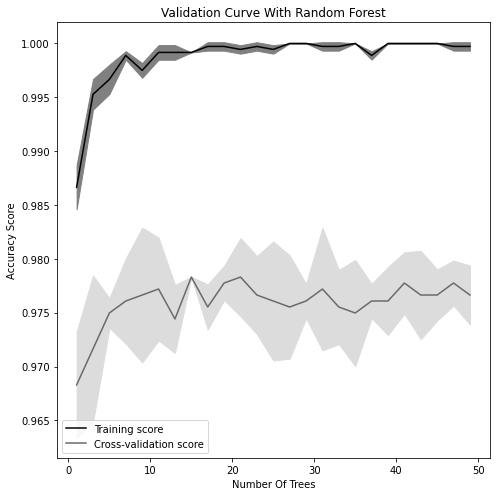

In [68]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

D'après le graphique, le score est le plus élevé pour environ 27 arbres de décision. Voyons si c'est le cas :

In [69]:
rf = RandomForestClassifier(n_estimators = 27, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [70]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))

[[430   1]
 [ 14   5]]
Accuracy : 0.9666666666666667


On remarque qu'effectivement, la précision a très légèrement augmenté.

# Random forest avec RandomizedSearchCV

Nous allons maintenant chercher les hyper-paramètres (nombre d'arbres et profondeur maximum des arbres) les plus optimaux pour notre modélisaton pour n_estimators allant de 10 à 1000 arbres de décision avec un pas de 10.

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [72]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [2, 100]},
                   random_state=42, verbose=2)

In [73]:
#On affiche les meilleurs parametres retenus par RandomizedSearchCV
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [74]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy of base model : ' + str(accuracy_score(y_test, y_pred)))

best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy of best model : ' + str(accuracy_score(y_test, y_pred)))

[[431   0]
 [ 13   6]]
Accuracy of base model : 0.9711111111111111
[[429   2]
 [ 12   7]]
Accuracy of best model : 0.9688888888888889


Le meilleur modèle est donc bien celui obtenu par l'optimisation des hyperparamètres puisqu'il présente une meilleure accuracy et sa matrice de confusion nous renvoie 7 vrais positifs contre 5 dans le modèle de base.

## Over-sampling avec SMOTE

Nos données sont déséquilibrées : il y a beaucoup plus de joueurs non sélectionnés que de joueurs sélectionnés. Nous allons donc les rééquilibrer par la méthode SMOTE pour essayer d'améliorer le modèle.

SMOTE = Synthetic Minority Oversampling TEchnique.

Cette méthode consiste à créer de manière synthétique des observations de la classe minoritaire afin de rééquilibrer les 2 classes.

In [75]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [76]:
#On affiche la taille de X_train
X_train.shape

(1798, 304)

In [77]:
#On affiche la taille de X_train_res. On remarque que le nombre de lignes a augmenté
X_train_res.shape

(3496, 304)

In [78]:
y_train['selected'].value_counts()

0.0    1748
1.0      50
Name: selected, dtype: int64

In [79]:
y_train_res['selected'].value_counts()

1.0    1748
0.0    1748
Name: selected, dtype: int64

In [80]:
#On applique le random forest sur nos données re-equilibrees
smote_model = RandomForestClassifier()
smote_model.fit(X_train_res, y_train_res)
y_pred_res = smote_model.predict(X_test)

In [81]:
confusion_matrix(y_test, y_pred_res)

array([[425,   6],
       [ 11,   8]])

Notons que dans notre cas, l'accuracy n'est pas une mesure pertinente car elle reflète le score global de la classification, or nous nous intéressons plutôt à l'optimisation des vrais positifs. Ainsi, pour déterminer le meilleur modèle, nous choisissons de mesurer la précision car nous voulons minimiser les faux positifs, alors que la métrique du recall est plus intéressante lorsque nous accordons plus d'importance aux faux négatifs.

La formule de la precision est donnée par :           Precision = TruePositive/(TruePositive+FalsePositive)

In [82]:
precision_smote_model = 11/(11+8)
print(precision_smote_model)

0.5789473684210527


Conclusion: précision de 57% pour le random forest avec SMOTE.

In [84]:
plot_confusion_matrix(smote_model, y_test, y_pred_res) 
plt.show()

ValueError: X has 1 features, but DecisionTreeClassifier is expecting 304 features as input.

# Régression Logistique

Testons un autre modèle pour ce problème : la regression logistique.

Un modèle de régression logistique permet de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression. Ce résultat varie toujours entre 0 et 1. Lorsque la valeur prédite est supérieure à un seuil, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure au même seuil, il ne l’est pas.

In [ ]:
model_LR = LogisticRegression(random_state=0)
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

In [ ]:
#On affiche la matrice de confusion
confusion_matrix(y_test, y_pred)

In [ ]:
#On calcule la precision
precision_model_LR = 5/(5+6)
print(precision_model_LR)

Conclusion : précision de 45% pour la regression linéaire.

Faisons la même chose pour des données ré-équilibrées :

In [ ]:
model_LR_res = LogisticRegression(random_state=0)
model_LR_res.fit(X_train_res, y_train_res)
y_pred_res = model_LR_res.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_res)

In [ ]:
precision_model_LR_res = 16/(16+27)
print(precision_model_LR_res)

Conclusion : précision de 37% pour la régression linéaire avec SMOTE.

# Conclusion

Au vu des résultats que nous venons d'obtenir, il apparaît que le meilleur modèle est le random forest avec oversampling, qui arrive à prédire avec succès la sélection de 8 défenseurs sur 19.

Pour ce projet, nous nous sommes restreint à la position de défenseur en ne travaillant qu'avec le dataframe defense_df. Pour compléter cette analyse, nous pourrions refaire ce travail de modélisation sur les dataframes des données des joueurs des autres positions.

A savoir : les données d'entrainement sont basées sur la sélection de Didier Deschamps: il s'agit d'une sélection humaine irrationnelle qui change au fil des années. C'est pourquoi aucun modèle ne pourrait reproduire les décisions prises à un instant t par le sélectionneur.